In [253]:
from keras import backend
from keras.layers import (Activation, Add, BatchNormalization, Conv2D,
                          DepthwiseConv2D, GlobalAveragePooling2D, Multiply,
                          Reshape, MaxPooling2D, AveragePooling2D)
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings("ignore")

In [137]:
"""MobileNet v2 models for Keras.
   (https://arxiv.org/abs/1801.04381)
"""
 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import backend as K
 
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
 
def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
 
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
 
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)
 
 
def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """
 
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)
 
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
 
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)
 
    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
 
    if r:
        x = Add()([x, inputs])
 
    return x
 
 
def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """
 
    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)
 
    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)
 
    return x
 
 
def MobileNetv2(input_shape, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = Input(shape=input_shape)
 
    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))
 
    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)
 
    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280
 
    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    # Replace with softmax cross-entropy activation function
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
 
    model = Model(inputs, output)
    # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)
    # Replace with cross-entropy loss
    model.compile(optimizer = Adam(lr = 1e-4), loss = "categorical_crossentropy", metrics = ['accuracy'])
    return model
 
    

In [138]:
model = MobileNetv2((224, 224, 3), 2, 1.0)
print(model.summary())

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 112, 112, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_179 (Batch  (None, 112, 112, 32  128        ['conv2d_171[0][0]']             
 Normalization)                 )                                                          

                                                                                                  
 conv2d_178 (Conv2D)            (None, 56, 56, 144)  3600        ['add_30[0][0]']                 
                                                                                                  
 batch_normalization_189 (Batch  (None, 56, 56, 144)  576        ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_895 (Activation)    (None, 56, 56, 144)  0           ['batch_normalization_189[0][0]']
                                                                                                  
 depthwise_conv2d_54 (Depthwise  (None, 28, 28, 144)  1440       ['activation_895[0][0]']         
 Conv2D)                                                                                          
          

                                                                                                  
 batch_normalization_200 (Batch  (None, 14, 14, 64)  256         ['conv2d_185[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_186 (Conv2D)            (None, 14, 14, 384)  24960       ['batch_normalization_200[0][0]']
                                                                                                  
 batch_normalization_201 (Batch  (None, 14, 14, 384)  1536       ['conv2d_186[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_903 (Activation)    (None, 14, 14, 384)  0           ['batch_normalization_201[0][0]']
          

/Users/huangboyuan/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


 batch_normalization_202 (Batch  (None, 14, 14, 384)  1536       ['depthwise_conv2d_58[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 activation_904 (Activation)    (None, 14, 14, 384)  0           ['batch_normalization_202[0][0]']
                                                                                                  
 conv2d_187 (Conv2D)            (None, 14, 14, 64)   24640       ['activation_904[0][0]']         
                                                                                                  
 batch_normalization_203 (Batch  (None, 14, 14, 64)  256         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_33 (A

                                                                                                  
 activation_911 (Activation)    (None, 14, 14, 576)  0           ['batch_normalization_213[0][0]']
                                                                                                  
 depthwise_conv2d_62 (Depthwise  (None, 14, 14, 576)  5760       ['activation_911[0][0]']         
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_214 (Batch  (None, 14, 14, 576)  2304       ['depthwise_conv2d_62[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 activation_912 (Activation)    (None, 14, 14, 576)  0           ['batch_normalization_214[0][0]']
          

                                                                  'batch_normalization_221[0][0]']
                                                                                                  
 conv2d_202 (Conv2D)            (None, 7, 7, 960)    154560      ['add_38[0][0]']                 
                                                                                                  
 batch_normalization_225 (Batch  (None, 7, 7, 960)   3840        ['conv2d_202[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_919 (Activation)    (None, 7, 7, 960)    0           ['batch_normalization_225[0][0]']
                                                                                                  
 depthwise_conv2d_66 (Depthwise  (None, 7, 7, 960)   9600        ['activation_919[0][0]']         
 Conv2D)  

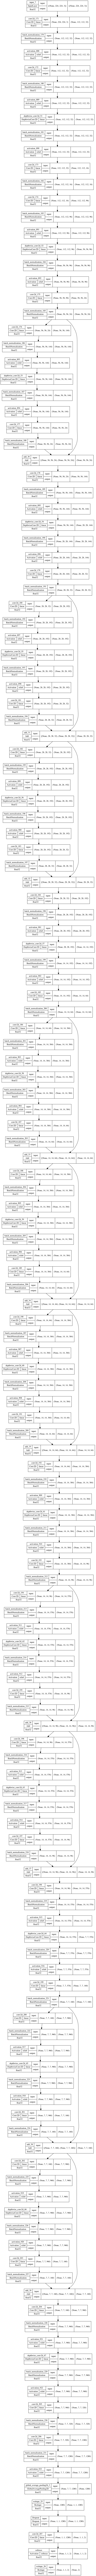

In [139]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_dtype = True, show_layer_activations=True, show_layer_names=True,
          show_shapes=True)

In [50]:
# split training, testing, and validation data
# training: test: validation = 7:2:1
import os
import random
import shutil
train_ratio = 0.7
test_ratio = 0.2
class SplitDataset():
    def __init__(self, dataset_dir, saved_dataset_dir, train_ratio=train_ratio, test_ratio=test_ratio, show_progress=False):
        self.dataset_dir = dataset_dir
        self.saved_dataset_dir = saved_dataset_dir
        if not os.path.exists(self.saved_dataset_dir):
            os.mkdir(self.saved_dataset_dir)
        self.saved_train_dir = saved_dataset_dir + "/train/"
        self.saved_valid_dir = saved_dataset_dir + "/valid/"
        self.saved_test_dir = saved_dataset_dir + "/test/"


        self.train_ratio = train_ratio
        self.test_radio = test_ratio
        self.valid_ratio = 1 - train_ratio - test_ratio

        self.train_file_path = []
        self.valid_file_path = []
        self.test_file_path = []

        self.index_label_dict = {}

        self.show_progress = show_progress

        if not os.path.exists(self.saved_train_dir):
            os.mkdir(self.saved_train_dir)
        if not os.path.exists(self.saved_test_dir):
            os.mkdir(self.saved_test_dir)
        if not os.path.exists(self.saved_valid_dir):
            os.mkdir(self.saved_valid_dir)


    def __get_label_names(self):
        label_names = []
        for item in os.listdir(self.dataset_dir):
            item_path = os.path.join(self.dataset_dir, item)
            if os.path.isdir(item_path):
                label_names.append(item)
        return label_names

    def __get_all_file_path(self):
        all_file_path = []
        index = 0
        for file_type in self.__get_label_names():
            self.index_label_dict[index] = file_type
            index += 1
            type_file_path = os.path.join(self.dataset_dir, file_type)
            file_path = []
            for file in os.listdir(type_file_path):
                single_file_path = os.path.join(type_file_path, file)
                file_path.append(single_file_path)
            all_file_path.append(file_path)
        return all_file_path

    def __copy_files(self, type_path, type_saved_dir):
        for item in type_path:
            src_path_list = item[1]
            dst_path = type_saved_dir + "%s/" % (item[0])
            if not os.path.exists(dst_path):
                os.mkdir(dst_path)
            for src_path in src_path_list:
                shutil.copy(src_path, dst_path)
                if self.show_progress:
                    print("Copying file "+src_path+" to "+dst_path)

    def __split_dataset(self):
        all_file_paths = self.__get_all_file_path()
        for index in range(len(all_file_paths)):
            file_path_list = all_file_paths[index]
            file_path_list_length = len(file_path_list)
            random.shuffle(file_path_list)

            train_num = int(file_path_list_length * self.train_ratio)
            test_num = int(file_path_list_length * self.test_radio)

            self.train_file_path.append([self.index_label_dict[index], file_path_list[: train_num]])
            self.test_file_path.append([self.index_label_dict[index], file_path_list[train_num:train_num + test_num]])
            self.valid_file_path.append([self.index_label_dict[index], file_path_list[train_num + test_num:]])

    def start_splitting(self):
        self.__split_dataset()
        self.__copy_files(type_path=self.train_file_path, type_saved_dir=self.saved_train_dir)
        self.__copy_files(type_path=self.valid_file_path, type_saved_dir=self.saved_valid_dir)
        self.__copy_files(type_path=self.test_file_path, type_saved_dir=self.saved_test_dir)


if __name__ == '__main__':
    data_path = './mask_dataset/'
    split_path = './split_data'
    split_dataset = SplitDataset(dataset_dir=data_path,
                                 saved_dataset_dir=split_path,
                                 show_progress=True)
    split_dataset.start_splitting()

Copying file ./mask_dataset/have_mask/OK-mask_0350.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0416.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0939.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0279.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0902.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/130.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/375.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0945.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/414.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0227.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/317.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0660.jpg to ./split_da

Copying file ./mask_dataset/have_mask/387.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0575.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0459.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0523.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/208.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/157.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0546.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0565.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/582.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/458.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/542.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/301.jpg to ./split_data/train/have_mask/
Copying

Copying file ./mask_dataset/have_mask/454.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0865.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0037.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1072.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0144.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0270.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0153.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0036.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/451.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/103.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/461.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1028.jpg to ./split_da

Copying file ./mask_dataset/have_mask/OK-mask_0770.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0721.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/255.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0007.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0779.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/560.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/263.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0569.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0340.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0932.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0781.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0786.jpg to .

Copying file ./mask_dataset/have_mask/OK-mask_0120.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/370.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0639.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0461.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0031.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0883.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0423.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1019.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0109.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1068.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0627.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-

Copying file ./mask_dataset/have_mask/OK-mask_0363.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0159.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0839.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0351.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0726.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1070.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/403.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0098.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0753.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/566.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/405.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0180.jpg to .

Copying file ./mask_dataset/have_mask/OK-mask_0685.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/80.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/292.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/216.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0229.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/47.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0739.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1010.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0895.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0056.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/85.jpg to ./split_data/train/have_mask/
Copying file ./mask_dataset/have_mask/293.jpg to ./split_data/train/have_mask/
C

Copying file ./mask_dataset/no_mask/64.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/763.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/4.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/634.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/722.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/227.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/684.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/829.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/432.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/410.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/570.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/355.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/751.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/

Copying file ./mask_dataset/no_mask/82.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000053.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000214.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/714.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/678.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/394.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/843.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000182.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/254.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/712.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/56.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/248.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000180.jpg to ./split_data/train/no_mask/
Cop

Copying file ./mask_dataset/no_mask/815.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/72.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/659.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/520.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000081.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/533.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/592.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/827.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000220.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000094.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/38.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/382.jpg to ./split_data/train/no_mask/
Copying file ./mask_dataset/no_mask/457.jpg to ./split_data/train/no_mask/
Copying f

Copying file ./mask_dataset/have_mask/OK-mask_0595.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/313.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/549.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/124.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/113.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0534.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/133.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0784.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1064.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/195.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0200.jpg to ./split_data/valid/have_mask/
Copying file ./mask_dataset/have_mask/258.jpg to ./split_data/valid/have_mask/
Copying

Copying file ./mask_dataset/no_mask/582.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/149.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/548.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/33.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/602.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/55.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/773.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/口罩_000030.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/no_mask/341.jpg to ./split_data/valid/no_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0746.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0471.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/373.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0998.jpg to ./split_dat

Copying file ./mask_dataset/have_mask/OK-mask_0420.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0333.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0725.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0067.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/51.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/413.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/139.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_1065.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0421.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0538.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0628.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0235.jpg to ./split_data/

Copying file ./mask_dataset/have_mask/229.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0132.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0848.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0917.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/OK-mask_0979.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/have_mask/203.jpg to ./split_data/test/have_mask/
Copying file ./mask_dataset/no_mask/口罩_000177.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/399.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/538.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/616.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/883.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/69.jpg to ./split_data/test/no_mask/
Copying file ./mask_dataset/no_mask/196.jpg to 

In [188]:
# Generate batch data for training tests as well as validation
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prep_fn(img):
    # Data normalization
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

def generate(batch, shape, ptrain, pval, ptest):
    # feature engineering
#     datagen1 = ImageDataGenerator(
#         preprocessing_function=prep_fn,
#         shear_range=0.2,
#         zoom_range=0.2,
#         rotation_range=90,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True)
    datagen1 = ImageDataGenerator(preprocessing_function=prep_fn)

    datagen2 = ImageDataGenerator(preprocessing_function=prep_fn)
    datagen3 = ImageDataGenerator(preprocessing_function=prep_fn)

    train_generator = datagen1.flow_from_directory(
        directory=ptrain,
        target_size=shape,
        batch_size=batch,
        class_mode='categorical',
    shuffle=True)
    print(train_generator.class_indices)

    validation_generator = datagen2.flow_from_directory(
        directory=pval,
        target_size=shape,
        batch_size=batch,
        class_mode='categorical',
    shuffle=True)

    test_generator = datagen3.flow_from_directory(
        directory=ptest,
        target_size=shape,
        batch_size=batch,
        class_mode='categorical',
        shuffle=False)

    num_train, num_val, num_test = 0, 0, 0
    for f in os.listdir(ptrain):
        num_train += len(os.listdir(os.path.join(ptrain, f)))  #

    for v in os.listdir(pval):
        num_val += len(os.listdir(os.path.join(pval, v)))
        # num_val += len(os.listdir(os.path.join(ptrain, v)))
    for v in os.listdir(ptest):
        num_test += len(os.listdir(os.path.join(ptest, v)))

    return train_generator, validation_generator, test_generator, num_train, num_val, num_test

In [141]:
#training model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

save_model = './save'  # Path to save the model
logs_path = "./logs"  # Path to save training log
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
check_path(save_model)
check_path(logs_path)

In [144]:
width = 224
height = 224  
batch_size = 32  # batchsize
learning_rate = 0.01  
epochs = 100 
train_path = "./split_data/train" 
val_path = "./split_data/valid"
test_path = "./split_data/test"


modelname = "mobileNetV2"
train_generator, validation_generator, test_generator, num_train, num_val, num_test= generate(batch=batch_size,
                                                                                     shape=(width, height),
                                                                                     ptrain=train_path,
                                                                                     pval=val_path,
                                                                                     ptest=test_path)
# Set early stop, stop after 15 consecutive loses do not fall
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
# Save the model, only the best model, only the model weights
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_model, f"{modelname}.h5"),
    monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)
# Check if the log folder exists, if it does, you don't have to create it
check_path(os.path.join(logs_path, modelname))
# Save the training process as an Excel file 
csv_save = CSVLogger(os.path.join(os.path.join(logs_path, modelname), f'{modelname}.csv'))
#Dynamic learning rate, 9 times in a row without dropping the loss, the learning rate will be on top of the original *0.5
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=9, verbose=1, factor=0.5)
# staring training
history = model.fit_generator(train_generator, validation_data=validation_generator,
                              verbose=1,
                              steps_per_epoch=num_train // batch_size,
                              validation_steps=num_val // batch_size,
                              epochs=epochs,
                              initial_epoch=0,
                              shuffle=True,
                              callbacks=[checkpoint, csv_save, earlystop, reduceLR])

Found 1874 images belonging to 2 classes.
{'have_mask': 0, 'no_mask': 1}
Found 269 images belonging to 2 classes.
Found 535 images belonging to 2 classes.


<ipython-input-144-87940bf43302>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=validation_generator,


Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.6862
Epoch 1: val_accuracy improved from -inf to 0.63672, saving model to ./save/mobileNetV2.h5
58/58 [==============================] - 209s 4s/step - loss: 0.5889 - accuracy: 0.6862 - val_loss: 0.6914 - val_accuracy: 0.6367 - lr: 2.0000e-04
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8426
Epoch 2: val_accuracy did not improve from 0.63672
58/58 [==============================] - 212s 4s/step - loss: 0.3660 - accuracy: 0.8426 - val_loss: 0.6620 - val_accuracy: 0.6250 - lr: 2.0000e-04
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.9072
Epoch 3: val_accuracy did not improve from 0.63672
58/58 [==============================] - 216s 4s/step - loss: 0.2407 - accuracy: 0.9072 - val_loss: 0.6624 - val_accuracy: 0.6328 - lr: 2.0000e-04
Epoch 4/100
58/58 [==============================] - ETA: 0s - loss: 0.1953 - acc

Epoch 28/100
58/58 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9902
Epoch 28: val_accuracy did not improve from 0.98438
58/58 [==============================] - 214s 4s/step - loss: 0.0252 - accuracy: 0.9902 - val_loss: 0.2918 - val_accuracy: 0.9336 - lr: 2.0000e-04
Epoch 29/100
58/58 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9902
Epoch 29: val_accuracy did not improve from 0.98438
58/58 [==============================] - 206s 4s/step - loss: 0.0250 - accuracy: 0.9902 - val_loss: 0.0910 - val_accuracy: 0.9727 - lr: 2.0000e-04
Epoch 30/100
58/58 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9924
Epoch 30: val_accuracy did not improve from 0.98438
58/58 [==============================] - 204s 4s/step - loss: 0.0172 - accuracy: 0.9924 - val_loss: 0.0999 - val_accuracy: 0.9766 - lr: 2.0000e-04
Epoch 31/100
58/58 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9935
Epoch 31: val_accur

In [145]:
# Visualization of overtraining loss as well as accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def plot_history(history, modelname):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(12, 4), dpi=100)
    plt.subplot(1,2,1)
    plt.plot(range(len(loss)), loss, label='loss')
    plt.plot(range(len(loss)), val_loss, label='val_loss')
    plt.grid()
    plt.legend()
    plt.title(f"{modelname}  loss")
    plt.subplot(1, 2, 2)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(range(len(acc)), acc, label='accuracy')
    plt.plot(range(len(acc)), val_acc, label='val_accuracy')
    plt.grid()
    plt.legend()
    plt.title(f"{modelname}  accuracy")
    check_path((os.path.join(logs_path,modelname)))
    plt.savefig(os.path.join(os.path.join(logs_path,modelname), 'train_log.jpg'))
    plt.show()

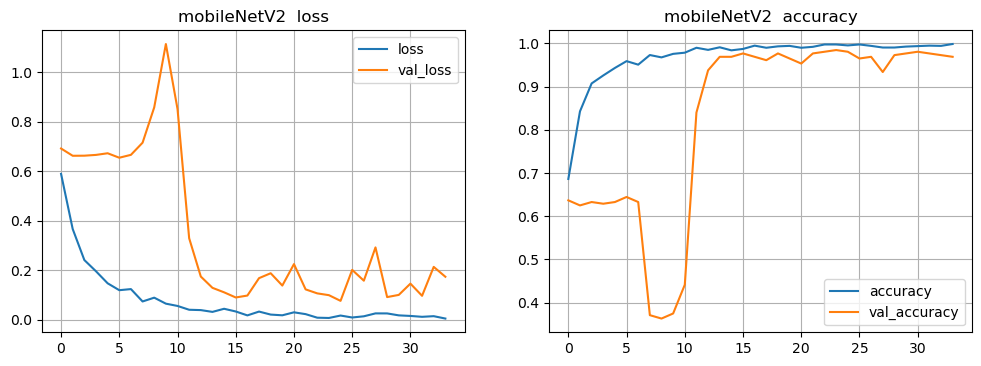

In [146]:
plot_history(history, modelname)

In [298]:
# Accuracy on the test
modelname = "mobileNetV2"
model = MobileNetv2((224, 224, 3), 2, 1.0)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.load_weights("./save/mobileNetV2.h5")
model.evaluate_generator(test_generator)

[0.104184091091156, 0.9607476592063904]

In [299]:
from sklearn.metrics import accuracy_score
y_true = test_generator.classes[test_generator.index_array]
predict = model.predict_generator(test_generator)
predict_label = np.argmax(predict,1)
accuracy_score(y_true, predict_label)

0.9607476635514018

In [300]:
# {'have_mask': 0, 'no_mask': 1}
class_dict = {'have_mask': 0, 'no_mask': 1}
import pandas as pd
def conf_matrix(y_true, y_predict, modelname):
    plt.figure(figsize=(5,2),dpi=100)
    matrix = pd.DataFrame(confusion_matrix(y_true, y_predict), columns=list(class_dict.keys()))
    matrix.index = matrix.columns
    sns.heatmap(matrix, annot=True, fmt='.20g')
    plt.title(f"{modelname} confusion_matrix")
    plt.savefig(os.path.join(os.path.join(logs_path,modelname), 'confusion_matrix.png'))
    plt.xticks(rotation=90)
    plt.show()


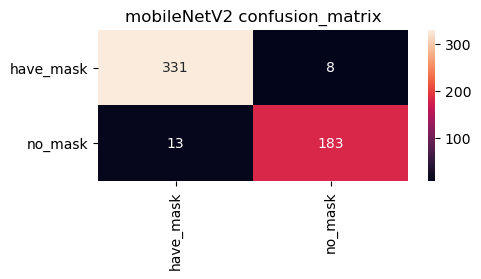

In [301]:
conf_matrix(y_true, predict_label, modelname)

In [302]:
def classifaction_report_csv(report):
    """Obtain the classification index for each category - P R f1""""
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_datas = line.split('      ')


        row_datas=list(map(lambda x:x.strip(),row_datas))
        row_data = []
        for r in row_datas:
            if not r=='':
                row_data.append(r)

        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    return df


def plot_report(report_df, modelname):
    """Visualize the above data as a heat map""""
    report_df.iloc[:, 1:] = report_df.iloc[:, 1:].astype(float)
    report_df.index = report_df['class']
    report_df = report_df.drop(['class'], axis=1)
    plt.figure(figsize=(6,4), dpi=100)
    ### annot is to show the value represented by the square out cmap color
    sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap="YlGnBu")
    plt.title(f"{modelname} classification heatmap")
    plt.savefig(os.path.join(os.path.join(logs_path, modelname), "classification_heatmap.png"))
    plt.show()

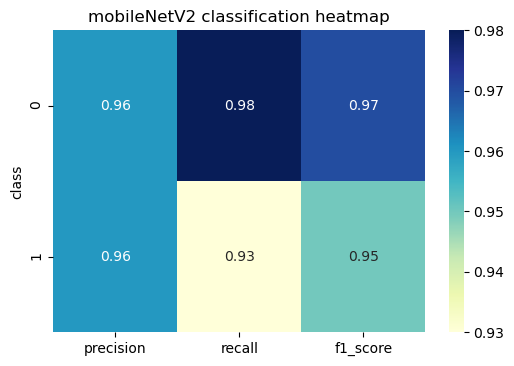

In [303]:
report = classification_report(y_true, predict_label)
report_df = classifaction_report_csv(report)
plot_report(report_df, modelname)

In [224]:
# 96% accuracy rate - further optimization

In [179]:
# Model optimization - develop warm_up dynamic learning rate
"""
Initial training is done at a very small learning rate to familiarize the network with the data.
As the training progresses, the learning rate slowly becomes larger, and after a certain point, the training is performed at the set initial learning rate.
Then after some inter, the learning rate slowly becomes smaller again; the learning rate changes: up - steady - down.
"""
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras import backend as K

class WarmupExponentialDecay(Callback):
    def __init__(self, lr_base=0.0002, lr_min=0.0, decay=0, warmup_epochs=0):
        self.num_passed_batchs = 0  # a counter
        self.warmup_epochs = warmup_epochs
        self.lr = lr_base  # learning_rate_base
        self.lr_min = lr_min  # Minimum starting learning rate, this code has not been implemented yet
        self.decay = decay  # Exponential decay rate
        self.steps_per_epoch = 0  # a counter

    def on_batch_begin(self, batch, logs=None):
        # params are some of the parameters that the model automatically passes to the Callback
        if self.steps_per_epoch == 0:
            # Prevent changes when running the validation set
            if self.params['steps'] == None:
                self.steps_per_epoch = np.ceil(1. * self.params['samples'] / self.params['batch_size'])
            else:
                self.steps_per_epoch = self.params['steps']
        if self.num_passed_batchs < self.steps_per_epoch * self.warmup_epochs:
            K.set_value(self.model.optimizer.lr,
                        self.lr * (self.num_passed_batchs + 1) / self.steps_per_epoch / self.warmup_epochs)
        else:
            K.set_value(self.model.optimizer.lr,
                        self.lr * ((1 - self.decay) ** (
                                    self.num_passed_batchs - self.steps_per_epoch * self.warmup_epochs)))
        self.num_passed_batchs += 1

    def on_epoch_begin(self, epoch, logs=None):
        # Used to output the learning rate, can be deleted
        print("learning_rate:", K.get_value(self.model.optimizer.lr))


In [181]:
model = MobileNetv2((224, 224, 3), 2, 1.0)
learning_rate = 1e-8
modelname = "mobileNetV2_opt"
train_generator, validation_generator, test_generator, num_train, num_val, num_test= generate(batch=batch_size,
                                                                                     shape=(width, height),
                                                                                     ptrain=train_path,
                                                                                     pval=val_path,
                                                                                     ptest=test_path)
# Set early stop, stop if loss does not drop for 15 consecutive times
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
# Save the model, only the best model, only the model weights
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_model, f"{modelname}.h5"),
    monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)
# Check if the log folder exists, if it does, you don't have to create it
check_path(os.path.join(logs_path, modelname))
# Save the training process as an Excel file 
csv_save = CSVLogger(os.path.join(os.path.join(logs_path, modelname), f'{modelname}.csv'))
# start training
history_opt = model.fit_generator(train_generator, validation_data=validation_generator,
                              verbose=1,
                              steps_per_epoch=num_train // batch_size,
                              validation_steps=num_val // batch_size,
                              epochs=epochs,
                              initial_epoch=0,
                              shuffle=True,
                              callbacks=[checkpoint, csv_save, earlystop,
                                         WarmupExponentialDecay(lr_base=0.0002, 
                                                                lr_min=0.00002,
                                                                warmup_epochs=2)])




Found 1874 images belonging to 2 classes.
{'have_mask': 0, 'no_mask': 1}
Found 269 images belonging to 2 classes.
Found 535 images belonging to 2 classes.


<ipython-input-181-16c4c133cd86>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_opt = model.fit_generator(train_generator, validation_data=validation_generator,


learning_rate: 0.0002
Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.6118
Epoch 1: val_accuracy improved from -inf to 0.64062, saving model to ./save/mobileNetV2_opt.h5
58/58 [==============================] - 264s 4s/step - loss: 0.6794 - accuracy: 0.6118 - val_loss: 0.6703 - val_accuracy: 0.6406
learning_rate: 1e-04
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7742
Epoch 2: val_accuracy did not improve from 0.64062
58/58 [==============================] - 241s 4s/step - loss: 0.5046 - accuracy: 0.7742 - val_loss: 0.6574 - val_accuracy: 0.6367
learning_rate: 0.0002
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8762
Epoch 3: val_accuracy improved from 0.64062 to 0.65625, saving model to ./save/mobileNetV2_opt.h5
58/58 [==============================] - 257s 4s/step - loss: 0.3199 - accuracy: 0.8762 - val_loss: 0.6446 - val_accuracy: 0.6562
learning_rate: 0

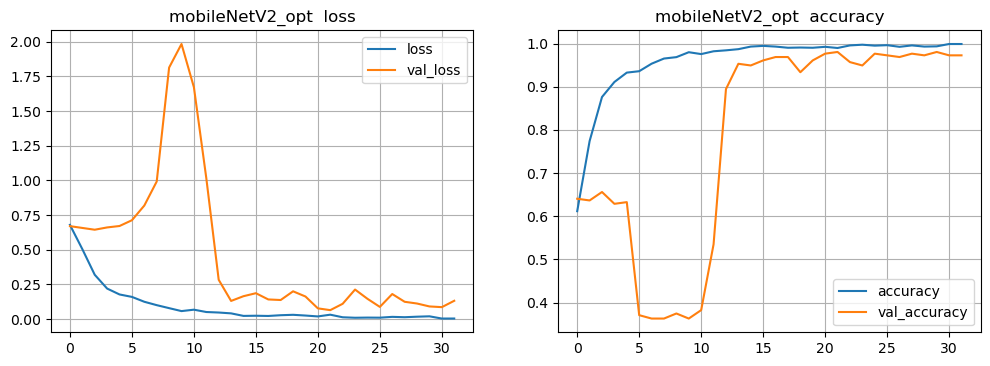

In [212]:
plot_history(history_opt, modelname)

In [304]:
# Increased accuracy to 98.8% on tests
modelname = "mobileNetV2_opt"
model_opt = MobileNetv2((224, 224, 3), 2, 1.0)
# model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_opt.load_weights("./save/mobileNetV2_opt.h5")
model_opt.evaluate_generator(test_generator)

[0.05516304448246956, 0.9887850284576416]

In [305]:
# Some other metrics: confusion matrix, etc.
y_true = test_generator.classes[test_generator.index_array]
predict_opt = model_opt.predict_generator(test_generator)
predict_label_opt = np.argmax(predict_opt,1)
accuracy_score(y_true, predict_label_opt)

0.9887850467289719

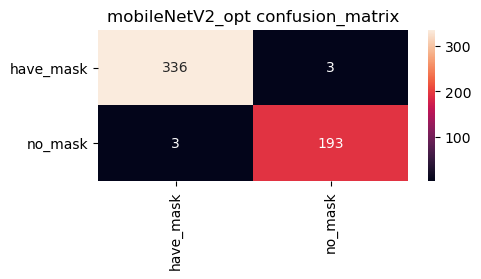

In [306]:
conf_matrix(y_true, predict_label_opt, modelname)

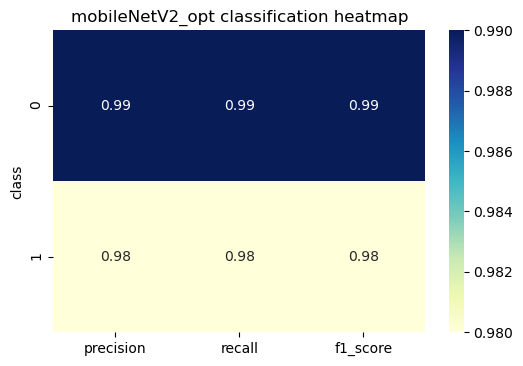

In [307]:
report_opt = classification_report(y_true, predict_label_opt)
report_df_opt = classifaction_report_csv(report_opt)
plot_report(report_df_opt, modelname)

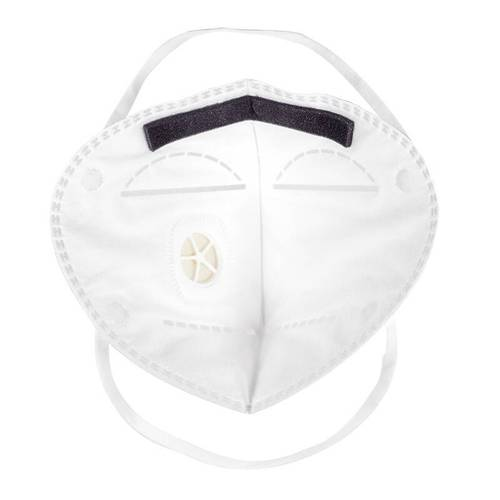

In [268]:
# Testing with the best model for a particular image
from PIL import Image
input_img = "./mask_dataset/no_mask/mask28.jpg"
array = Image.open(input_img)
array

In [254]:
import cv2
a1=np.array(array)
a2 = prep_fn(a1)
a3 = cv2.resize(a2,(224,224))
a3 = np.expand_dims(a3, axis=0)
model_1= MobileNetv2((224, 224, 3), 2, 1.0)
# model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1.load_weights("./save/mobileNetV2_opt.h5")
predicts = model_1.predict(a3)
result = np.argmax(predicts, 1)
l = list(class_dict.keys())[result[0]]
print("predict this image is:",l)

predict this image is: no_mask


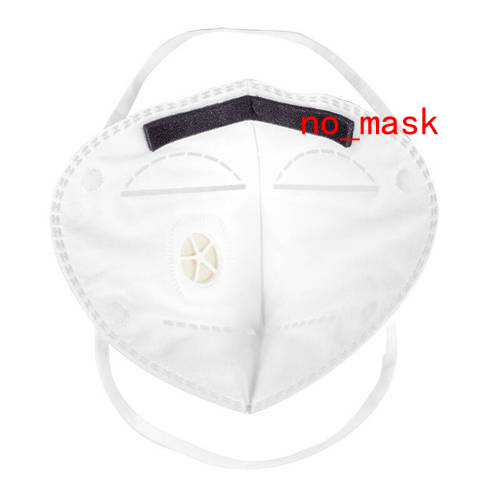

In [269]:
from PIL import Image, ImageFont, ImageDraw # Import Module
draw = ImageDraw.Draw(array) #Modify image
textsize = 40
ft = ImageFont.truetype("./KaiTi.ttf", textsize)
draw.text((300,100), l, fill = (255, 0 ,0), font=ft) #Use ImageDraw's built-in function to write text on the image
array

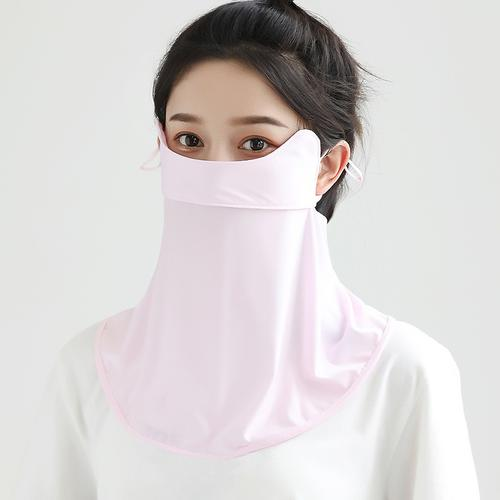

In [274]:
input_img = "./mask_dataset/no_mask/mask49.jpg"
array = Image.open(input_img)
array

In [275]:
a1=np.array(array)
a2 = prep_fn(a1)
a3 = cv2.resize(a2,(224,224))
a3 = np.expand_dims(a3, axis=0)
model_1= MobileNetv2((224, 224, 3), 2, 1.0)
# model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1.load_weights("./save/mobileNetV2_opt.h5")
predicts = model_1.predict(a3)
result = np.argmax(predicts, 1)
l = list(class_dict.keys())[result[0]]
print("predict this image is:",l)

predict this image is: no_mask


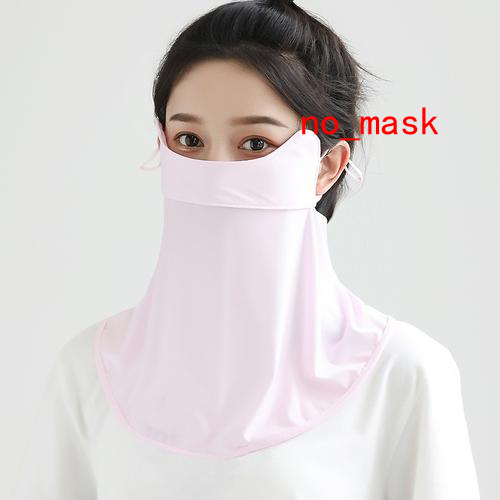

In [276]:
draw = ImageDraw.Draw(array) 
textsize = 40
ft = ImageFont.truetype("./KaiTi.ttf", textsize)
draw.text((300,100), l, fill = (255, 0 ,0), font=ft) 
array

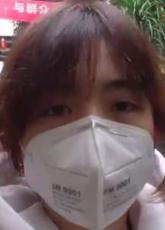

In [292]:
input_img = "./split_data/test/have_mask/115.jpg"
array = Image.open(input_img)
array

In [290]:
a1=np.array(array)
a2 = prep_fn(a1)
a3 = cv2.resize(a2,(224,224))
a3 = np.expand_dims(a3, axis=0)
model_1= MobileNetv2((224, 224, 3), 2, 1.0)
# model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1.load_weights("./save/mobileNetV2_opt.h5")
predicts = model_1.predict(a3)
result = np.argmax(predicts, 1)
l = list(class_dict.keys())[result[0]]
print("predict this image is:",l)

predict this image is: have_mask


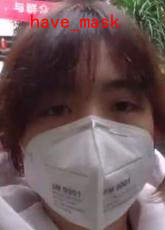

In [293]:
draw = ImageDraw.Draw(array) 
textsize = 20
ft = ImageFont.truetype("./KaiTi.ttf", textsize)
draw.text((30,10), l, fill = (255, 0 ,0), font=ft) 
array